In [342]:
#LIBRARIES + IMPORT DATA

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
phones_new = pd.read_csv("/Users/ooganam/Desktop/phone_dataset.csv",error_bad_lines=False)
phones_new = phones_new[pd.notnull(phones_new['approx_price_EUR'])]
phones_new = phones_new.reset_index(drop = True) 

phones_new['year'] = phones_new['announced'].str.extract('(\d\d\d\d)', expand=True)
phones_new['year'].fillna(phones_new['year'].value_counts().index[0],inplace=True)
todelete = []
for row in range(phones_new.shape[0]):

    if str(phones_new['year'][row]) not in ['2017', '2016']:
        
          todelete.append(row)
            
phones_new.drop(todelete, axis = 0, inplace = True)

phones_new = phones_new.reset_index(drop = True) 


In [343]:
#DATA CLEANING
phones_new = phones_new.drop('CPU', axis = 1)
# switch weight columns into floats
phones_new.weight_g = phones_new.weight_g.convert_objects(convert_numeric=True)
phones_new.weight_oz = phones_new.weight_oz.convert_objects(convert_numeric=True)

# a function to turn removable battery data into a boolean feature
def removable(battery):
    if battery[0] == 'Removable':
        return True
    elif battery[0] == 'Non-removable':
        return False
    else:
        return np.nan

a = phones_new.battery.astype(str).apply(lambda x: (re.findall('(Non-removable|Removable|)\s*(Li-Ion|Li-Po|Li-ion|Li-po|NiMH|)\s*(\d*)',x))) 

phones_new['battery_removable'] = a.apply(lambda x: removable(x[0])) # the first regex indicates 'removable' / 'non-removable'


phones_new['battery_type'] = a.apply(lambda x: (x[0])[1]) # the second regex indicates 'Li-Ion' / 'Li-Po' / 'Li-ion' / 'Li-po' / 'NiMH'
phones_new['battery_mah'] = a.apply(lambda x: ((x[0])[2])).convert_objects(convert_numeric=True) # the third regex gives the numerical data for mah
phones_new.drop(columns=['battery'],inplace=True)



a = phones_new.display_size.astype(str).apply(lambda x: 
                                        (re.findall('(\d*\.\d*)\s*inches(\s*\(.(\d*\.\d*)|)',x))) 
# functions to parse data from display_resolution regex

def display_size_inches(regex):
    if regex == []:
        return np.nan
    else:
        return float((regex[0])[0])
    
def screen_to_body_ratio(regex):
    if regex == []:
        return np.nan
    elif regex[0][-1] is None:
        return np.nan
    else:
        return (regex[0][-1])
    
phones_new['display_size_inches'] = a.apply(lambda x: display_size_inches(x))
phones_new['screen_to_body_ratio_%'] = a.apply(lambda x: screen_to_body_ratio(x)).convert_objects(convert_numeric=True)
phones_new.drop(columns=['display_size'],inplace=True)

b = phones_new.dimensions.astype(str).apply(lambda x: 
                                        (re.findall('(\d*\.\d*|\d*)\smm\sthickness',x)))

# convert regex data into numerical data
# return value as a list
def dimension_conversion(regex):
    if len(regex) == 0: # empty regex
        return []
    elif len(regex) == 1 & isinstance(regex[0],str): # regex coming from thickneww only data
        new_regex = []
        try:            
            new_regex.append(float(regex[0]))
        except:
            pass
        return new_regex
    elif (len(regex) >= 1) & isinstance(regex[0],tuple): # regex coming from full dimension data
        new_regex = list(regex[0])
        for i in range(len(new_regex)):
            try:
                new_regex[i] = float(regex[0][i])
            except:
                pass
        return new_regex
    else:
        return []
    
def length(x):
    if len(x) == 3:
        if x[0] is not None:
            return x[0]
        else:
            return np.nan
    else:
        return np.nan
    
def width(x):
    if len(x) == 3:
        if x[1] is not None:
            return x[1]
        else:
            return np.nan
    else:
        return np.nan
    
def thickness(x):
    if len(x) == 3:
        if x[2] is not None:
            return x[2]
        else:
            return np.nan
    elif len(x) == 1:
        if x[0] is not None:
            return x[0]
        
        else:
            return np.nan
    else:
        return np.nan
    
c = a.apply(lambda x: dimension_conversion(x)) + b.apply(lambda x: dimension_conversion(x))
length = c.apply(lambda x: length(x))
width = c.apply(lambda x: width(x))
thickness = c.apply(lambda x: thickness(x))
phones_new['length_mm'] = length
phones_new['width_mm'] = width
phones_new['thickness_mm'] = thickness
phones_new.drop(columns=['dimensions'],inplace=True)

# process internal_memory info

phones_new=phones_new[phones_new['approx_price_EUR'].isnull()==0]


# GPU  (graphics processing unit) column will be categorial type

a_regex = '(""|Adreno|Intel|Mali|Broadcom|PowerVR|ULP|Vivante|Nvidia|Kepler|3D|Mediatek|SGX531u|VideoCore)'
GPU_replacements = {'':0, 'Adreno':1,'Intel':2,'Mali':3,'Broadcom':4,'PowerVR':5,'ULP':6,'Vivante':7,'Nvidia':8,'Kepler':9
                   ,'3D':10,'Mediatek':11,'SGX531u':12,'VideoCore':13}

#Extract Using Regex
phones_new['GPU_new'] = phones_new['GPU'].str.extract(a_regex).fillna('')
#Look up values from dictionary
phones_new['GPU_new'] = phones_new['GPU_new'].apply(lambda x: GPU_replacements.get(x,''))

#creating a binary column - GPS_new if there is a GPS in model
check_list = ['Yes', 'GPS']
regstr = '|'.join(check_list)
phones_new['GPS_new']=phones_new['GPS']
# df_new['GPS_new'] = np.where(df_new['GPS'].isin(check_list),'YES','NO')
phones_new['GPS_new']=phones_new['GPS_new'].str.contains(regstr, case=False, na=False)
phones_new['GPS_new']=[1 if boolean == True else 0 for boolean in phones_new['GPS_new']]

phones_new['primary_cam_MP']=phones_new["primary_camera"].str.split(' ',expand=True)[0]
phones_new['primary_cam_MP'].fillna(0,inplace=True)
phones_new['primary_cam_MP'].replace('2MP',2,inplace=True)
phones_new['primary_cam_MP'].replace('5MP|',5,inplace=True)
phones_new['primary_cam_MP'].replace('600',0,inplace=True)
phones_new['primary_cam_MP'].replace(['SVGA','Yes.','QVGA','Yes|','CIF','No','VGA|','Yes','Dual','VGA'],0,inplace=True)

phones_new['secondary_cam_MP']=phones_new["secondary_camera"].str.split(' ',expand=True)[0]
phones_new['secondary_cam_MP'].fillna(0,inplace=True)

phones_new['secondary_cam_MP'].replace('8MP',8,inplace=True)
phones_new['secondary_cam_MP'].replace('1.3MP',1.3,inplace=True)
phones_new['secondary_cam_MP'].replace(['No','Yes','QCIF','0.','QVGA','Videocalling','CIF','0','VGA|','HD','Dual','VGA','Spy','VGA@15fps','QCIF@15fps','VGA/','720p','Videocall',],0,inplace=True)
# OS  (Operation System) column will be int type

phones_new=phones_new[phones_new['length_mm']!=0]
phones_new=phones_new[phones_new['length_mm']!=float('nan')]

#change data types (length_mm,Year, primary_cam_MP, secondary_cam_MP) to numeric
phones_new['year'] = phones_new['year'].apply(lambda x: int(x))
phones_new['primary_cam_MP'] = phones_new['primary_cam_MP'].apply(lambda x: float(x))
phones_new['secondary_cam_MP'] = phones_new['secondary_cam_MP'].apply(lambda x: float(x))
phones_new['length_mm']=phones_new['length_mm'].apply(lambda x: float(x))

# drop rows where price is over 1000 EURO


for j in range(len(phones_new['approx_price_EUR'])):
    if re.search('[a-zA-Z]+', phones_new['approx_price_EUR'][j]) is not None:
        phones_new.drop(j, axis = 0, inplace = True)
phones_new = phones_new.drop(phones_new[phones_new['approx_price_EUR'].astype(int) >=1000].index)
phones_new = phones_new.reset_index(drop = True) 


In [345]:
def countbands(string):
    string = str(string)
    counter = string.count("/") + 1
    if string == "":
        return 0
    return counter

def totalbandwith(string):
    string = str(string)
    if string == "":
        return 0.0
    toreturn = string.split()
    numberofbands = countbands(string)
    counter = 0
    for i in toreturn[1:numberofbands]:
        if "AWS" in i:
            counter += 1700.0
        elif string ==' CDMA 1xEVDO (800 / 1900 MHz)':
            counter = 2700.0
        else:
            if i != "/":
                counter += float(i)
    return counter

def fourGbands(string):
    string = str(string)
    totalcount = 0
    if "(" not in string:
        return (countbands(string), totalbandwith(string))
    else:
        length = len(string)
        parencounter = 0
        counter = 0
        accumulator = ""
        while counter < length:
            if string[counter] == "(":
                while string[counter] != ")":
                    if string[counter] != "(":
                        accumulator += string[counter]
                    counter+=1
                if accumulator == "1700/2100":
                    accumulator = 1900.0
                elif re.search('[a-zA-Z]+', accumulator) is not None:
                    accumulator = 0
                totalcount += float(accumulator)
                accumulator = ""
            else:
                counter += 1
    return ((string.count("|") + 1), totalcount)

def extractmemory(string):
    if string != string:
        return 0.0
    toreturn = string.split()
    if "|" in toreturn[0]:
        unit = toreturn[0][0:len(toreturn[0])]
        number = toreturn[1]
        
    else:
        number, unit = toreturn[0], toreturn[1]
    finalvalue = 0
    
    if "/" in number:
        multval = number.split("/")
        number = multval[0]
    conversion = 1
    if number == "4GB":
        conversion = 1000
        number = 4
    if unit == "GB":
        conversion = 1000
    if unit == "KB":
        conversion = .001
    return float(number) * conversion
        
def resolution(string):
    tobesplit = string.split(" ")
    return (float(tobesplit[0]), float(tobesplit[2]))
    
def network(string):

    if string == string:
        if string == "HSPA":
            return [0,0,0]
        standardaccum = 0
        maxcat = 0
        EVDO = 0
        text = string.split() 
        if "/" in text[1]:
            for mbps in text[1].split("/"):
                standardaccum += float(mbps)
        else:
            standardaccum = 0
        for chunk in text:
            if "Cat" in chunk:
                if int(chunk[len(chunk)-1]) > maxcat:
                    maxcat = int(chunk[len(chunk)-1])
            if "EV-DO" in chunk:
                EVDO = 1
        return [standardaccum, maxcat, EVDO]    
    else:
        return [0, 0, 0]
    
def findOS(string):
    for i in OSlist:
        if i in string:
            return (True, i)
    return (False, 0)

def OSedition(string):
    if "Microsoft" in string:
        return 10
    else:
        for j in string.split():
            if "." in j:
                return j.split(".")[0]

#OSlist = ['Maemo', 'Danger', 'MeeGo', 'MS', 'Android', 'Tizen', 'LiMo', 'OPhone', 'iOS', 'Bada', 'Microsoft', 'Amazon', 'LG', 'Linux', 'bada', 'Symbian', 'Sailfish', 'Nucleus', 'MediaTek', 'Open', 'Tencent', 'Linux', 'BlackBerry', '768', 'WinCE', 'Wearable', 'Nokia', 'Linux-based', 'Firefox', 'Palm', 'Android', 'Windows', 'HP']
#preparing the columns to be one hot encoded
#2G categories
phones_new['2Ggsm'] = 0

#3G categories
phones_new["3Ghsdpa"] = 0

phones_new["sim_or"] = 0
phones_new["sim_micro"] = 0
phones_new["sim_single"] = 0


phones_new['network_cat'] = 0
phones_new['max_network_cat'] = 0
phones_new['EVDO_network_cat'] = 0

phones_new['res_x']=0
phones_new['res_y']=0

#for os in OSlist:
 #   phones_new[os] = 0
    
rowstodelete = []
#for loop that executes one hot encoding 


for i in range(phones_new.shape[0]):
    twogee = phones_new['2G_bands'][i] 
    threegee = phones_new['3G_bands'][i]
    fourgee = phones_new['4G_bands'][i]
    sim = phones_new['SIM'][i]
    #os = phones_new['OS'][i]
    netreturned = network(phones_new['network_speed'][i])
    print(i, netreturned)
    netcat = netreturned[0]
    maxnetcat = netreturned[1]
    evdonetcat = netreturned[2]
    phones_new['network_cat'][i] = netcat
    phones_new['max_network_cat'][i] = maxnetcat
    phones_new['EVDO_network_cat'][i] = evdonetcat
    
    if twogee == twogee:
        #2G categories
     
        if "GSM" in twogee:
            phones_new['2Ggsm'][i] = 1

        
    #3G categories
    if threegee == threegee:
       
        if "HSDPA" in threegee:
            phones_new["3Ghsdpa"][i] = 1
    #SIM
    if sim == sim:
        if "or" in sim:
            phones_new["sim_or"][i] = 1
        if "Micro" in sim:
            phones_new["sim_micro"][i] = 1
        if "Single" in sim:
            phones_new["sim_single"][i] = 1
    
    #osbool, ostype = findOS(os.split()[0])
    #if osbool:
     #   phones_new[ostype][i] = OSedition(os)
    #else:
     #   rowstodelete.append(i)
        
    phones_new['res_x'][i] = resolution(phones_new['display_resolution'][i])[0]
    phones_new['res_y'][i] = resolution(phones_new['display_resolution'][i])[1]
    
    
#phones_new.drop(rowstodelete, axis = 0, inplace = True)

        
phones_new['num2Gbands'] = [countbands(i) for i in phones_new['2G_bands']]
phones_new['total2Gbandwith'] = [totalbandwith(i) for i in phones_new['2G_bands']]

phones_new['num3Gbands'] = [countbands(i) for i in phones_new['3G_bands']]
phones_new['total3Gbandwith'] = [totalbandwith(i) for i in phones_new['3G_bands']]

phones_new['num4Gbands'] = [fourGbands(i)[0] for i in phones_new['4G_bands']]
phones_new['total4Gbandwith'] = [fourGbands(i)[1] for i in phones_new['4G_bands']]

phones_new['GPRS'] = phones_new['GPRS'].map({'Yes': 1, 'No': 0})
phones_new['EDGE'] = phones_new['EDGE'].map({'Yes': 1, 'No': 0})

phones_new['battery_removable'] = phones_new['battery_removable'].map({True: 1, False: 0})
phones_new['battery_type'] = phones_new['battery_type'].map({'':10000, 'Li-Ion': 1, 'Li-Po': 0})

phones_new['newRAM'] = [extractmemory(i) for i in phones_new['RAM']]
phones_new['newinternalmemory'] = [extractmemory(i) for i in phones_new['internal_memory']]
phones_new.drop(['RAM', 'internal_memory', '2G_bands', '3G_bands', '4G_bands'], axis = 1, inplace = True)

phones_new = phones_new.reset_index(drop = True) 
                         

0 [53.7, 4, 0]
1 [47.96, 4, 0]
2 [0, 0, 0]
3 [0, 0, 0]
4 [0, 0, 0]
5 [0, 4, 0]
6 [47.96, 4, 0]
7 [47.96, 4, 0]
8 [53.7, 4, 0]
9 [0, 4, 0]
10 [0, 0, 0]
11 [47.96, 4, 0]
12 [47.96, 4, 0]
13 [47.96, 6, 0]
14 [47.96, 4, 0]
15 [47.96, 4, 0]
16 [47.96, 4, 0]
17 [47.96, 4, 0]
18 [47.96, 6, 0]
19 [0, 0, 0]
20 [0, 0, 0]
21 [0, 4, 0]
22 [26.86, 0, 0]
23 [26.86, 4, 0]
24 [26.86, 6, 0]
25 [26.86, 6, 0]
26 [26.86, 4, 0]
27 [26.86, 4, 0]
28 [26.86, 0, 0]
29 [26.86, 4, 0]
30 [47.96, 9, 1]
31 [47.96, 9, 1]
32 [47.96, 4, 1]
33 [0, 0, 0]
34 [0, 0, 0]
35 [0, 0, 0]
36 [0, 0, 0]
37 [0, 0, 0]
38 [0, 0, 0]
39 [47.96, 9, 1]
40 [47.96, 9, 1]
41 [47.96, 4, 1]
42 [0, 4, 0]
43 [53.7, 4, 0]
44 [53.7, 4, 0]
45 [53.7, 4, 0]
46 [47.96, 6, 0]
47 [47.96, 4, 0]
48 [47.96, 4, 0]
49 [0, 0, 0]
50 [47.96, 2, 0]
51 [47.96, 6, 0]
52 [0, 0, 0]
53 [47.96, 6, 0]
54 [26.86, 4, 0]
55 [47.96, 4, 0]
56 [47.96, 6, 0]
57 [0, 6, 0]
58 [0, 0, 0]
59 [0, 0, 0]
60 [47.96, 4, 0]
61 [47.96, 4, 0]
62 [47.96, 6, 0]
63 [47.96, 4, 0]
64 [47.96, 

519 [53.7, 4, 0]
520 [0, 4, 0]
521 [0, 4, 0]
522 [0, 4, 0]
523 [47.96, 6, 0]
524 [0, 4, 0]
525 [47.96, 4, 0]
526 [0, 4, 0]
527 [0, 4, 0]


In [346]:
phones_new['new_display_resolution'] = 0
def resolution(string):
    print(string)
    if string == string:
        tobesplit = string.split(" ")
        return float(tobesplit[0]) * float(tobesplit[2])
    else:
        return 0.0
for i in range(phones_new.shape[0]):
     phones_new['new_display_resolution'][i] = resolution(phones_new['display_resolution'][i]) 



720 x 1280 pixels (~210 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
1920 x 1200 pixels (~224 ppi pixel density)
720 x 1280 pixels (~267 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
720 x 1280 pixels (~282 ppi pixel density)
720 x 1280 pixels (~245 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
720 x 1280 pixels (~267 ppi pixel density)
480 x 854 pixels (~196 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
600 x 1024 pixels (~170 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
720 x 1280 pixels (~267 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1440 x 2560 pixels (~534 ppi pixel density)
1080 x 1920 pixels (~424 ppi pixel density)
600 x 1024 pixels (~170 ppi pixel density)
540 x 960 pixels (~184 ppi pixel density)
720 x 1280 pixels (~245 ppi pixel density)
480 x 800 pixels (~233 ppi pixel density)
720 x 1

480 x 854 pixels (~196 ppi pixel density)
720 x 1280 pixels (~267 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1080 x 1920 pixels (~403 ppi pixel density)
1440 x 2560 pixels (~515 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1440 x 2560 pixels (~464 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1200 x 1920 pixels (~224 ppi pixel density)
800 x 1280 pixels (~149 ppi pixel density)
1200 x 1920 pixels (~283 ppi pixel density)
800 x 1280 pixels (~189 ppi pixel density)
1200 x 1920 pixels (~283 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
480 x 800 pixels (~207 ppi pixel density)
480 x 854 pixels (~218 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)


1080 x 1920 pixels (~367 ppi pixel density)
1080 x 1920 pixels (~386 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
360 x 360 pixels (~278 ppi pixel density)
360 x 360 pixels (~278 ppi pixel density)
360 x 360 pixels (~278 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
1080 x 1920 pixels (~401 ppi pixel density)
480 x 800 pixels (~233 ppi pixel density)
1440 x 2560 pixels (~515 ppi pixel density)
1440 x 2560 pixels (~518 ppi pixel density)
720 x 1280 pixels (~267 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
800 x 1280 pixels (~216 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
1440 x 2560 pixels (~576 ppi pixel density)
720 x 1280 pixels (~294 ppi pixel density)
1080 x 1920 pixels (~386 ppi pixel density)
1080 x 1920 pixels (~424 ppi pixel density)
1080 x 1920 pixels (~367 ppi pixel density)
720 

In [347]:
phones_new = phones_new.sample(frac=1).reset_index(drop=True)
phones_new['width_mm'] = [extractnum[3:len(extractnum)] if extractnum == extractnum else np.nan for extractnum in phones_new['width_mm']]

delunnamed = 0
for counter, value in enumerate(phones_new.columns):
    if "Unnamed" in value:
        delunnamed = counter
    
phones_new.drop(["network_technology", 'display_resolution', 'Unnamed: 29', 'memory_card','OS',"network_speed", "GPS", "GPU",'announced', 'SIM', 'display_type', 'Chipset', 'primary_camera', 'secondary_camera'], axis = 1, inplace = True)
phones_new.fillna(0, axis = 1, inplace = True)

brands = phones_new.pop("brand")
model = phones_new.pop("model")
brands_train = brands[0:300]
brands_test = brands[300:phones_new.shape[0]]
model_train = model[0:300]
model_test = model[300:phones_new.shape[0]]


phones_new = phones_new.convert_objects(convert_numeric=True)
phones_new = phones_new.astype(float)

X_train = phones_new.iloc[0:300]
X_test = phones_new.iloc[300:phones_new.shape[0]]

Y_train = X_train.pop("approx_price_EUR")
Y_test = X_test.pop("approx_price_EUR")


In [348]:
phones_new.fillna(0, axis = 1, inplace = True)


brands_train = brands[0:300]
brands_test = brands[300:phones_new.shape[0]]
model_train = model[0:300]
model_test = model[300:phones_new.shape[0]]


phones_new = phones_new.convert_objects(convert_numeric=True)
phones_new = phones_new.astype(float)

X_train = phones_new.iloc[0:300]
X_test = phones_new.iloc[300:phones_new.shape[0]]

Y_train = X_train.pop("approx_price_EUR")
Y_test = X_test.pop("approx_price_EUR")


In [351]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score 
from sklearn.model_selection import RandomizedSearchCV


params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]}

rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = params, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)
Y_preds = rf_random.predict(X_test)
print(r2_score(Y_test, Y_preds))




Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.8min finished


0.6608934275943071


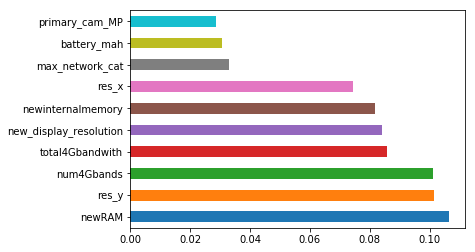

In [352]:
feat_importances = pd.Series(rf_random.best_estimator_.feature_importances_, index=X_train.columns)
topfeatures = feat_importances.nlargest(10)
topfeatures.plot(kind='barh')

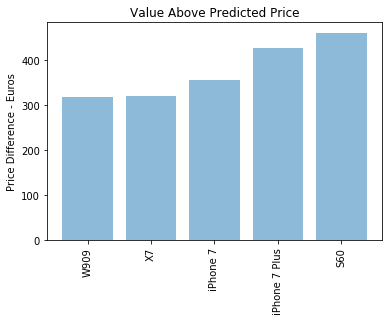

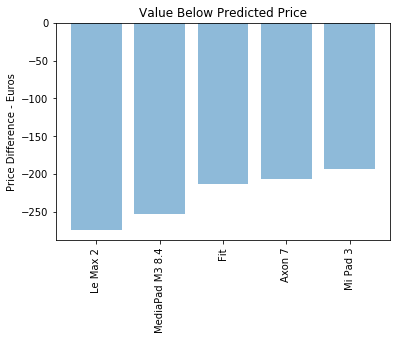

In [376]:
valuelist = []
for counter, value in enumerate(Y_test):
    toappend = value - Y_preds[counter]
    valuelist.append((model_test[counter+300],toappend))
    
from operator import itemgetter
valuelist = sorted(valuelist,key=itemgetter(1))

lowestvalue = valuelist[0:5]
highestvalue = valuelist[-5:len(valuelist)]

x_pos = np.arange(len(lowestvalue))

names_bestphones = [x[0] for x in highestvalue]
resid_bestphones = [x[1] for x in highestvalue]
names_worstphones = [x[0] for x in lowestvalue]
resid_worstphones = [x[1] for x in lowestvalue]

plt.bar(names_bestphones, resid_bestphones, align='center', alpha=0.5)
plt.xticks(x_pos, names_bestphones, rotation = 'vertical')
plt.ylabel('Price Difference - Euros')
plt.title('Value Above Predicted Price')
plt.autoscale()
plt.show()

plt.bar(names_worstphones, resid_worstphones, align='center', alpha=0.5)
plt.xticks(x_pos, names_worstphones, rotation = 'vertical')
plt.ylabel('Price Difference - Euros')
plt.title('Value Below Predicted Price')
plt.autoscale()
plt.show()

    

    

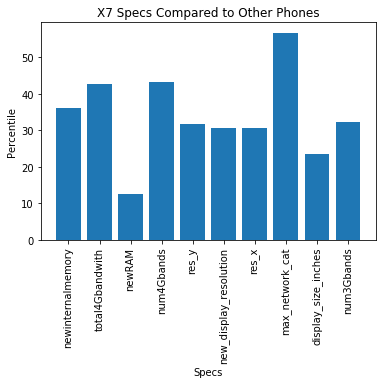

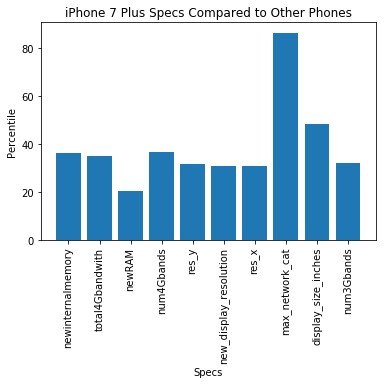

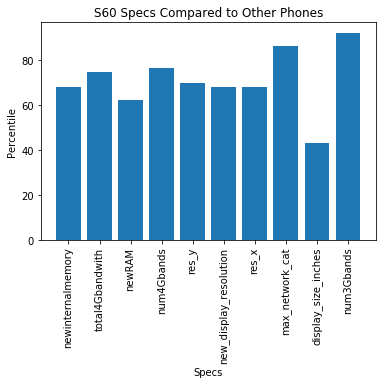

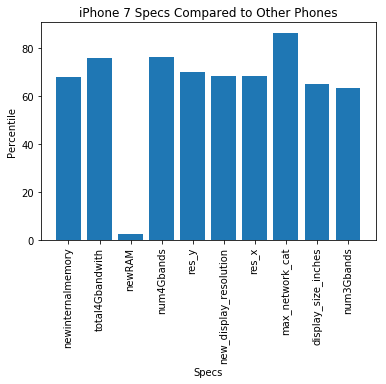

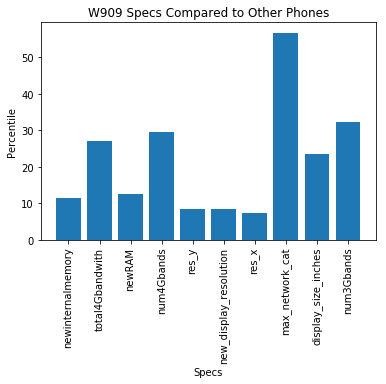

In [377]:
from scipy.stats import percentileofscore as pct

def findindices(namearray):
    
    toreturn = []
    if type(namearray) != list:
        namearray = [namearray]
    
    for counter, name in enumerate(model):
        if name in namearray:
            toreturn.append((counter,name))
    return toreturn

bestindices = findindices(names_bestphones)
worstindices = findindices(names_worstphones)

x_pos = np.arange(len(df.columns))


for tup in bestindices:
    percentilelist = []
    for col in df.columns:
        percentilelist.append(pct(df[col],df[col][tup[0]]))
    plt.bar(df.columns, percentilelist)
    plt.xticks(x_pos, df.columns, rotation = 'vertical')
    plt.title(tup[1] + " Specs Compared to Other Phones")
    plt.xlabel("Specs")
    plt.ylabel("Percentile")
    plt.show()

    

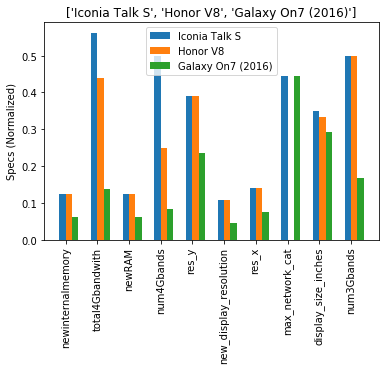

In [378]:
def comparephones(phonelist):
    phonespecs = []
    for phone in phonelist:
        phonespecs.append(df.iloc[findindices(phone)[0][0]])
    
    x_pos = np.arange(len(df.columns))
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.2       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    rects = []
    for numphone in range(len(phonespecs)):
        rects.append(ax.bar(ind+width*numphone, phonespecs[numphone], width))
        
    ax.set_ylabel('Specs (Normalized)')
    ax.set_title(phonelist)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(df.columns, rotation = 'vertical')
    ax.legend([r[0] for r in rects], phonelist)
    plt.show()

#phone comparison test

comparephones(['Iconia Talk S', 'Honor V8', 'Galaxy On7 (2016)'])


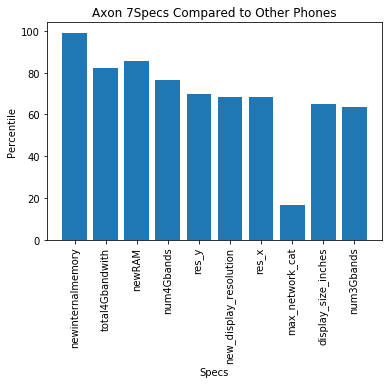

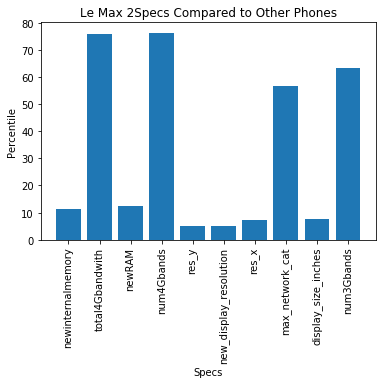

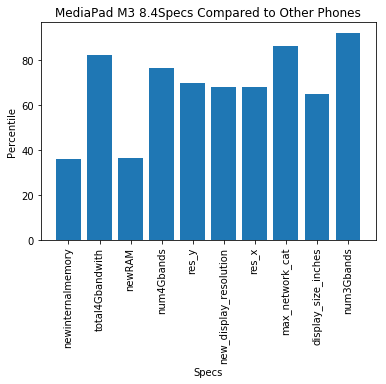

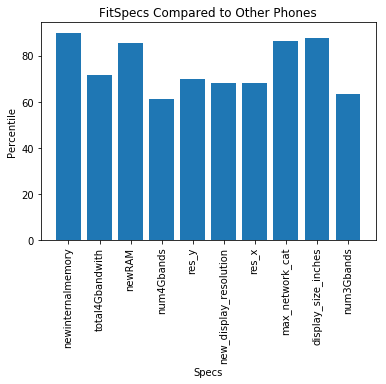

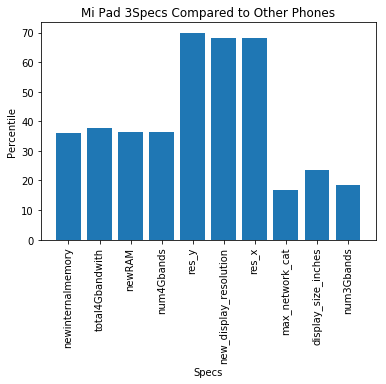

In [379]:
for tup in worstindices:
    percentilelist = []
    for col in df.columns:
        percentilelist.append(pct(df[col],df[col][tup[0]]))
    plt.bar(df.columns, percentilelist)
    plt.xticks(x_pos, df.columns, rotation = 'vertical')
    plt.title(tup[1] + "Specs Compared to Other Phones")
    plt.xlabel("Specs")
    plt.ylabel("Percentile")
    plt.show()

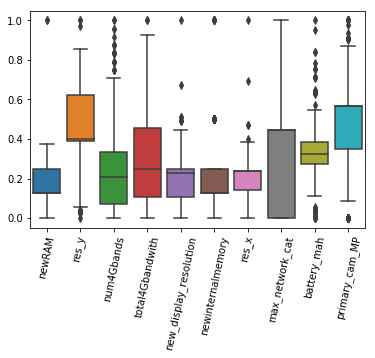

In [383]:
import seaborn as sns

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
reducedphones = phones_new[topfeatures.index.values]
x_scaled = min_max_scaler.fit_transform(reducedphones)
df = pd.DataFrame(data = x_scaled)
df.columns = topfeatures.index.values
ax = sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=78)
print("")

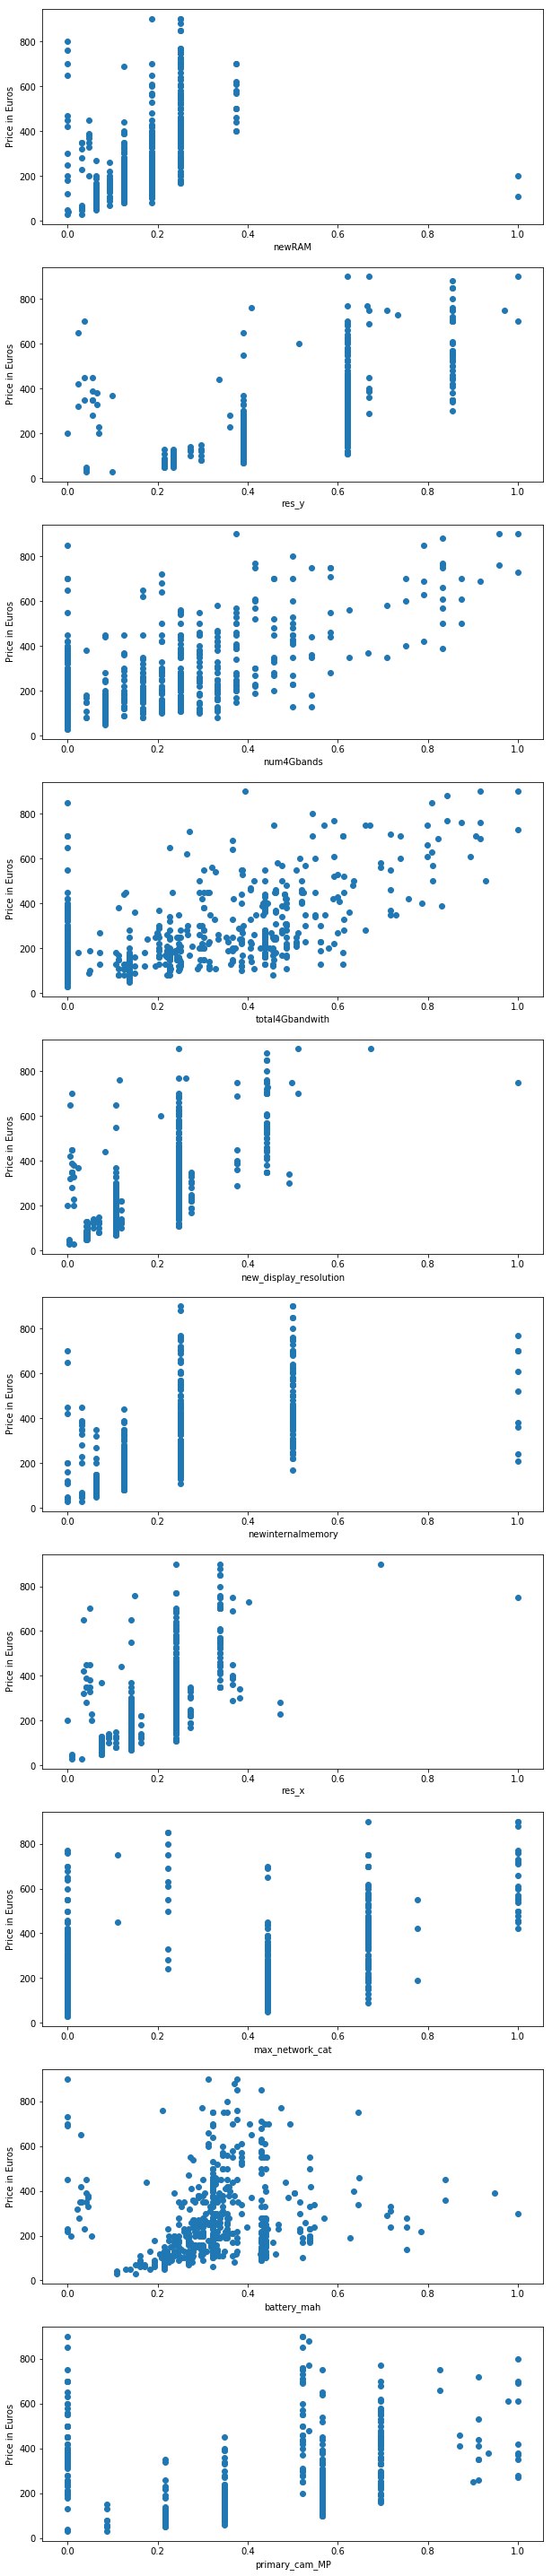

In [386]:
length = len(df.columns)

plt.figure(figsize=(10, 40))
for j in range(length):
    col = df.columns[j]
    plt.subplot(length, 1, j+1)
    plt.scatter(df[col], phones_new['approx_price_EUR'])
    plt.subplot(length,1, j+1).set_xlabel(col)
    plt.subplot(length,1, j+1).set_ylabel("Price in Euros")
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.4)
plt.show()

In [387]:
from collections import Counter, defaultdict
d = defaultdict(list)
cnt = Counter()

for brand in brands:
    d[brand] = [0 for i in range(df.shape[1])]
    cnt[brand] += 1

average = list(df.mean(axis = 0))

for counter in range(df.shape[0]):
    d[brands[counter]] = d[brands[counter]] + (df.iloc[counter] / cnt[brands[counter]])
    
    

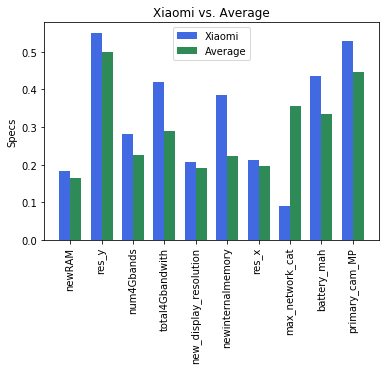

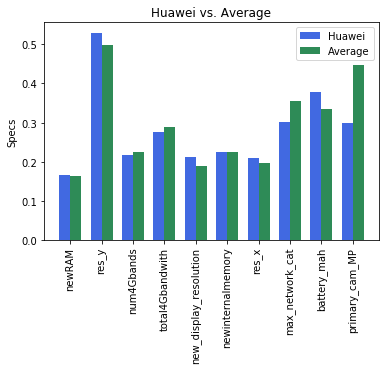

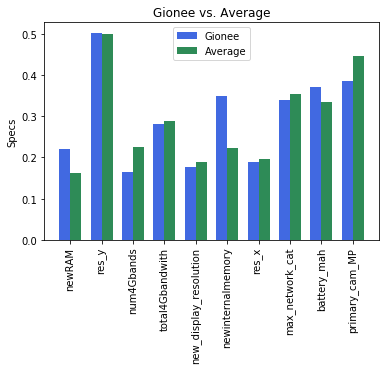

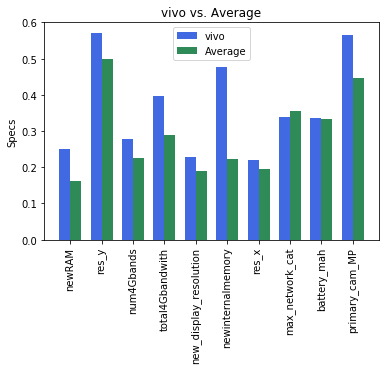

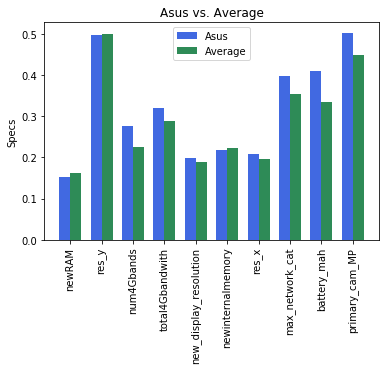

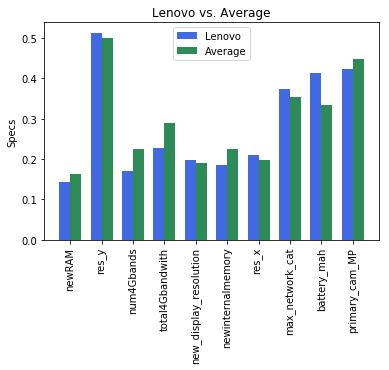

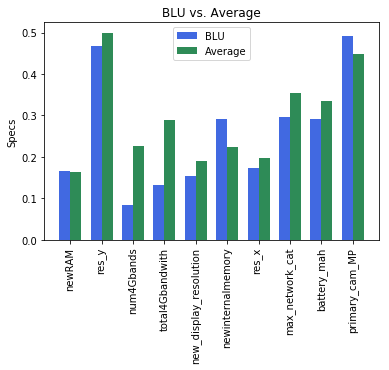

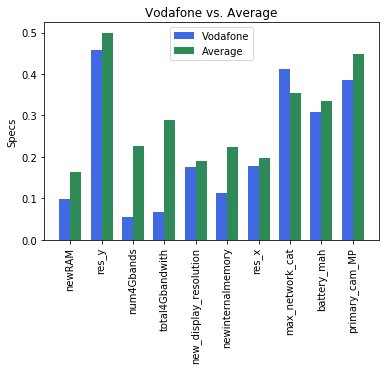

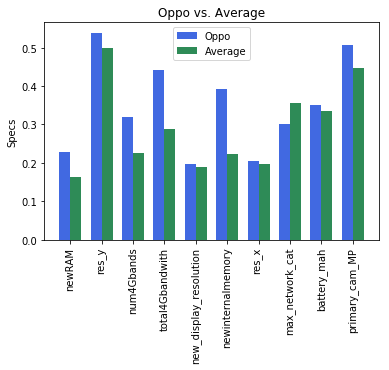

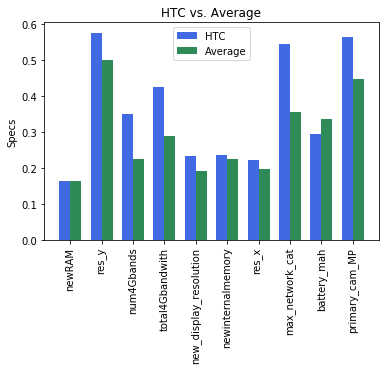

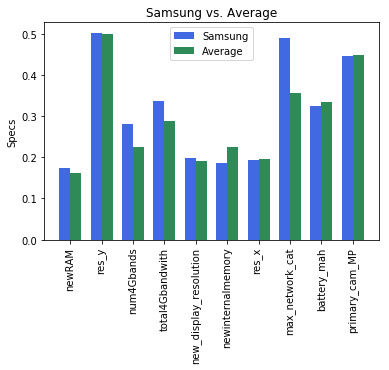

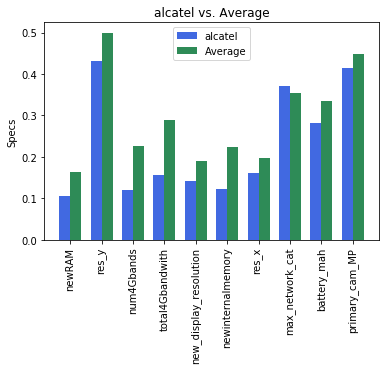

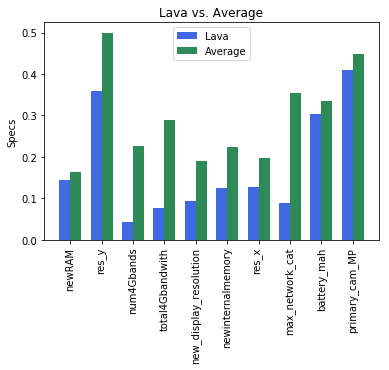

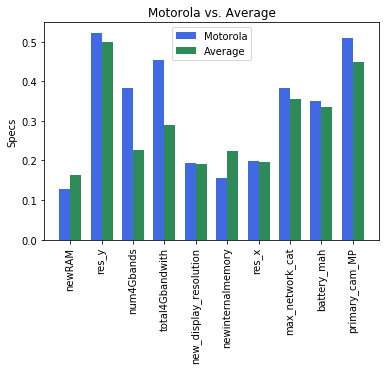

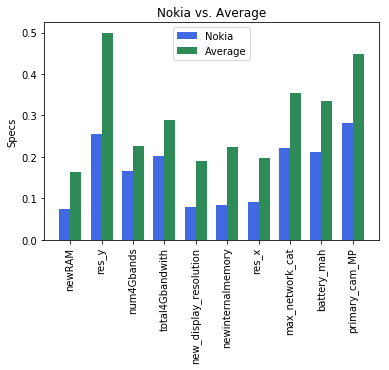

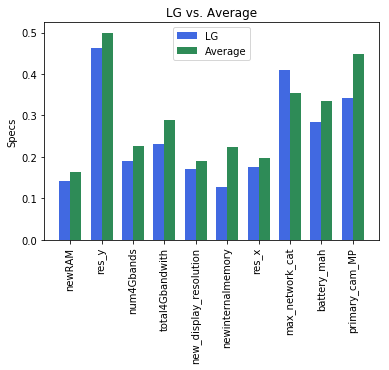

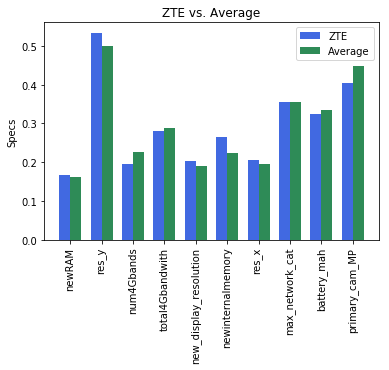

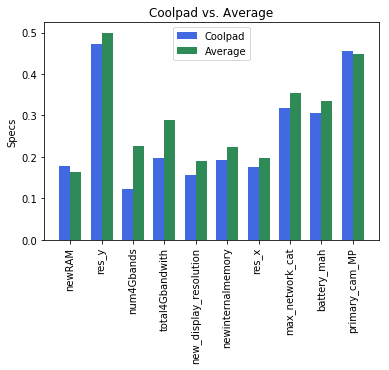

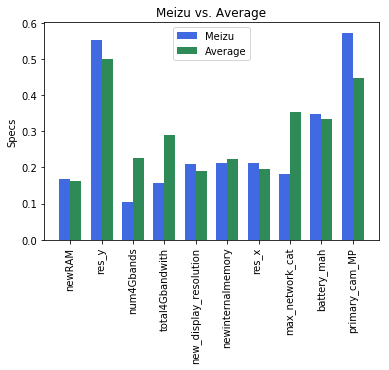

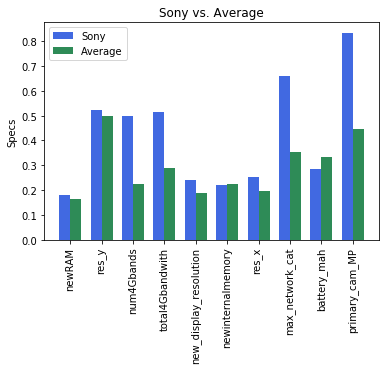

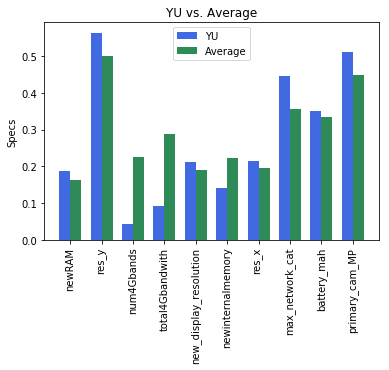

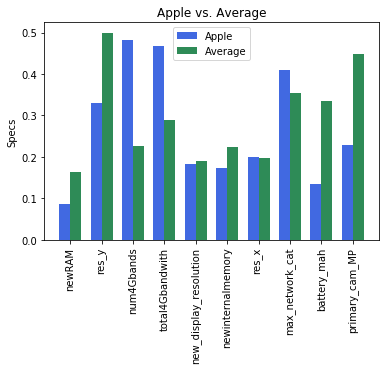

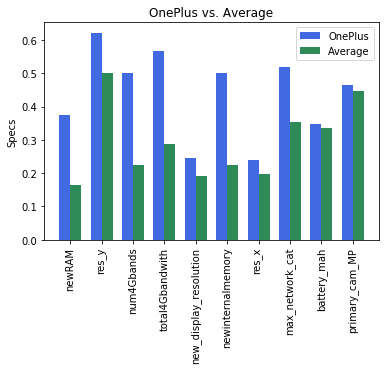

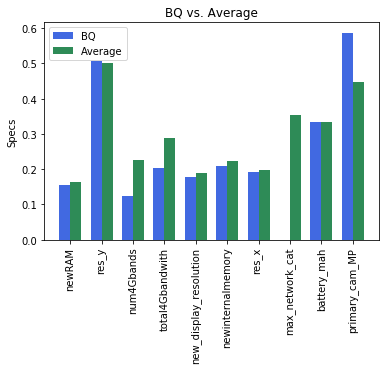

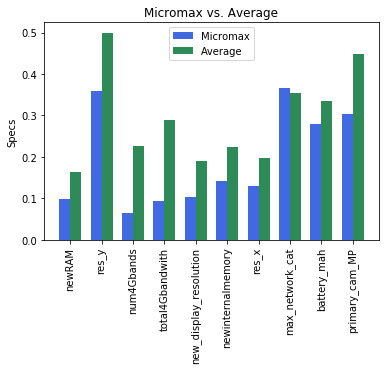

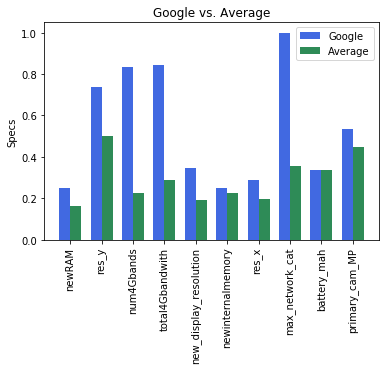

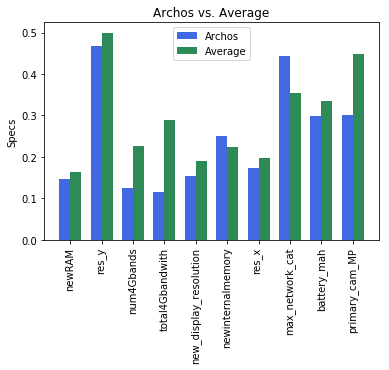

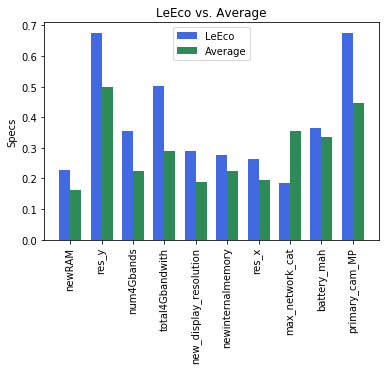

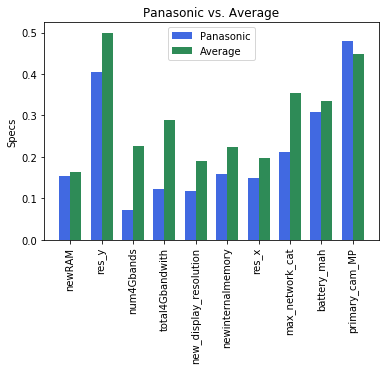

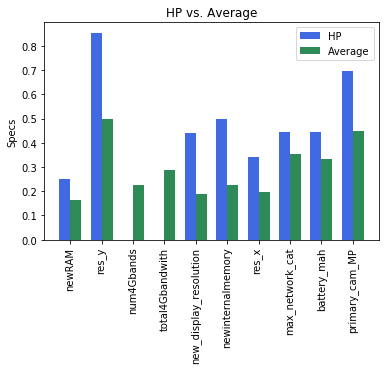

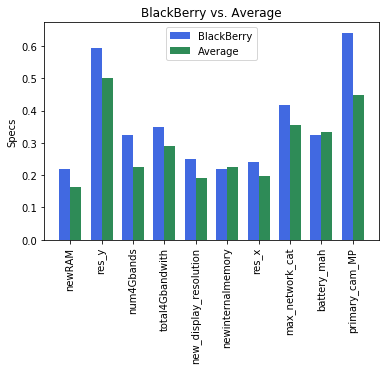

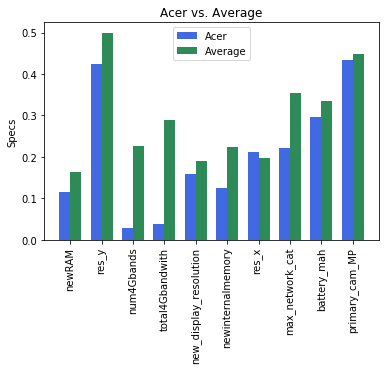

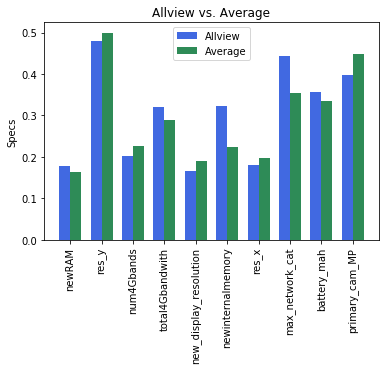

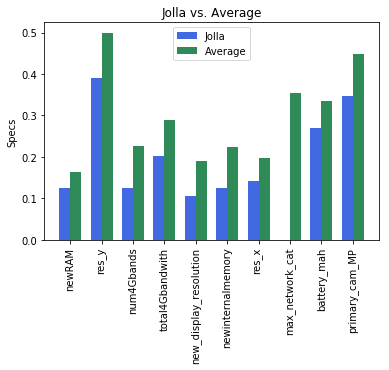

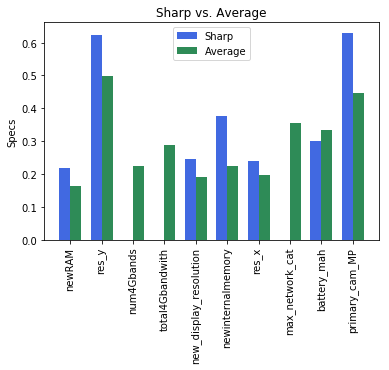

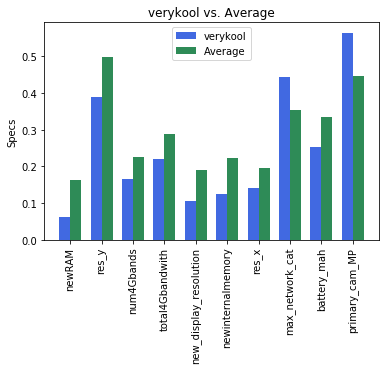

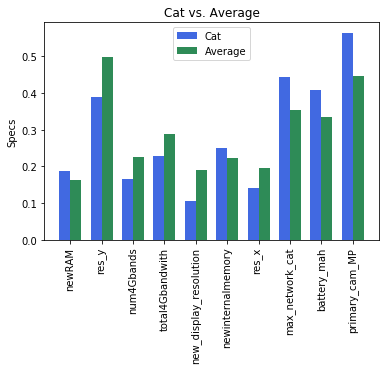

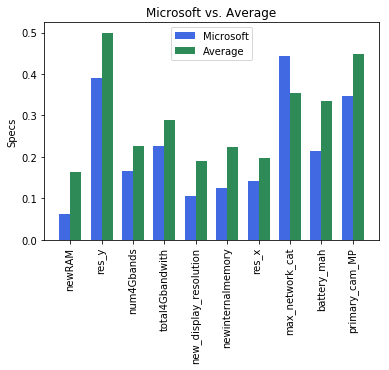

In [388]:
N = 10


for key in d:

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    
    
    rects1 = ax.bar(ind, d[key], width, color='royalblue')
    rects2 = ax.bar(ind+width, average, width, color='seagreen')

    ax.set_ylabel('Specs')
    ax.set_title(key + " vs. Average")
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(df.columns, rotation = 'vertical')
    ax.legend( (rects1[0], rects2[0]), (key, 'Average') )

    plt.show()

In [403]:
totalcount = Counter()
avgcount = Counter()

for brand in brands_test:
    totalcount[brand] += 1
    
values = []


for counter, value in enumerate(Y_preds):
    avgcount[brands_test[counter+300]] = avgcount[brands_test[counter+300]] + ((value - Y_test[counter+300]) / totalcount[brands_test[counter+300]])
    
avgcount = avgcount.most_common()
    


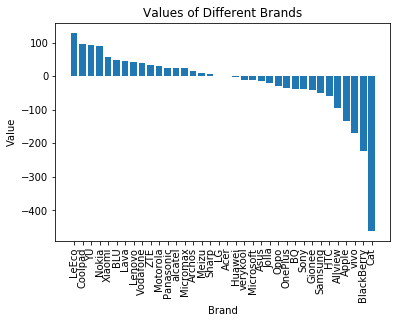

In [412]:

x_pos = np.arange(len(avgcount))
plt.bar([x[0] for x in avgcount], [x[1] for x in avgcount])
plt.xticks(x_pos, [x[0] for x in avgcount], rotation = 'vertical')
plt.title('Values of Different Brands')
plt.xlabel("Brand")
plt.ylabel("Value")
plt.show()